# Springs Density

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import os
from matplotlib.ticker import ScalarFormatter
from tqdm import tqdm

In [2]:
path_to_springs_shapefile = r"C:\Users\rl587\Documents\GitHub\Arizona-Karst\Data\Input"
os.chdir(path_to_springs_shapefile)
os.listdir(path_to_springs_shapefile)

['AZHUC8p_bound',
 'AZHUC8p_bound.cpg',
 'AZHUC8p_bound.dbf',
 'AZHUC8p_bound.prj',
 'AZHUC8p_bound.sbn',
 'AZHUC8p_bound.sbx',
 'AZHUC8p_bound.shp',
 'AZHUC8p_bound.shp.xml',
 'AZHUC8p_bound.shx',
 'AZHUC8p_bound.zip',
 'NHDPoint_Spring_AZHU_UTM12N',
 'NHDPoint_Spring_AZHU_UTM12N.cpg',
 'NHDPoint_Spring_AZHU_UTM12N.dbf',
 'NHDPoint_Spring_AZHU_UTM12N.prj',
 'NHDPoint_Spring_AZHU_UTM12N.sbn',
 'NHDPoint_Spring_AZHU_UTM12N.sbx',
 'NHDPoint_Spring_AZHU_UTM12N.shp',
 'NHDPoint_Spring_AZHU_UTM12N.shp.xml',
 'NHDPoint_Spring_AZHU_UTM12N.shx',
 'NHDPoint_Spring_AZHU_UTM12N.zip']

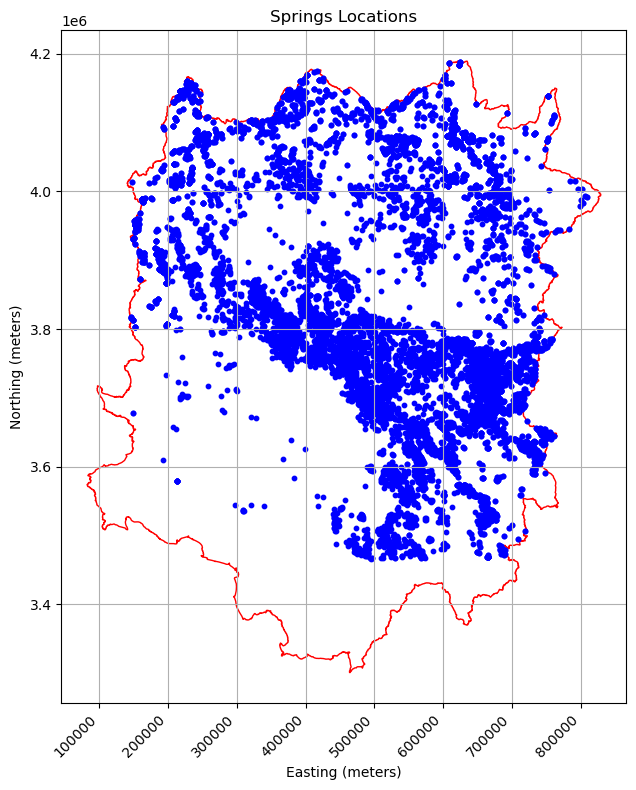

In [13]:

# Step 1: Load the shapefiles
spring_points_path = 'NHDPoint_Spring_AZHU_UTM12N.shp'
AZ_bound_path = 'AZHUC8p_bound.shp'

gdf_spring = gpd.read_file(spring_points_path)
gdf_bound = gpd.read_file(AZ_bound_path)

# Step 2: Project the shapefiles to NAD 83 2011 UTM Zone 12N
gdf_spring = gdf_spring.to_crs(epsg=6341)  # EPSG code for NAD 83 2011 UTM Zone 12N
gdf_bound = gdf_bound.to_crs(epsg=6341)

# Step 3: Display the shapefiles to verify input data distribution
fig, ax = plt.subplots(figsize=(10, 8))
gdf_bound.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)  # Plot boundary with no fill color
gdf_spring.plot(ax=ax, color='blue', markersize=10)  # Plot spring points

# Customize plot
ax.set_title('Springs Locations')
ax.set_xlabel('Easting (meters)')
ax.set_ylabel('Northing (meters)')
ax.grid(True)

# Remove scientific notation from the y-axis
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

# Clean up the axes so they aren't overlapping
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [14]:
# Step 4: Calculate Point Density using KDE with progress bar
def calculate_point_density(gdf, bandwidth, cell_size):
    # Extract coordinates
    x = gdf.geometry.x
    y = gdf.geometry.y
    
    # Create a grid of points
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    x_grid, y_grid = np.mgrid[x_min:x_max:cell_size, y_min:y_max:cell_size]
    
    # Stack the grid coordinates
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    
    # Create kernel density estimate
    values = np.vstack([x, y])
    kernel = gaussian_kde(values, bw_method=bandwidth)
    
    # Calculate density with a progress bar
    density = np.zeros(x_grid.shape)
    for i in tqdm(range(positions.shape[1]), desc="Calculating Density"):
        density += kernel(positions[:, i])
    density = np.reshape(density.T, x_grid.shape)
    
    return x_grid, y_grid, density

**Bandwidth:** Determines the smoothness of the density estimate. A smaller bandwidth means a more detailed and localized density estimate, while a larger bandwidth results in a smoother and more generalized density surface.

**Cell Size:** Defines the resolution of the output density raster. Smaller cell sizes result in higher resolution rasters, while larger cell sizes produce coarser rasters.

Calculating density with bandwidth=500 and cell_size=500


Calculating Density: 100%|█████████████████████████████████████████████████| 1914744/1914744 [16:45<00:00, 1903.48it/s]


Density min: 4.767493110422201e-11, max: 4.767493110422201e-11


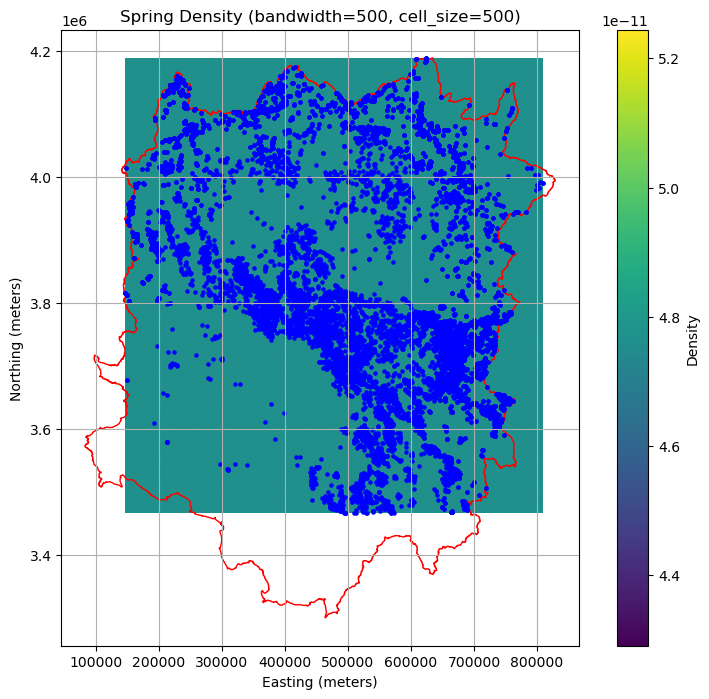

Calculating density with bandwidth=500 and cell_size=1000


Calculating Density: 100%|███████████████████████████████████████████████████| 478686/478686 [02:10<00:00, 3662.96it/s]


Density min: 1.1918732745546034e-11, max: 1.1918732745546034e-11


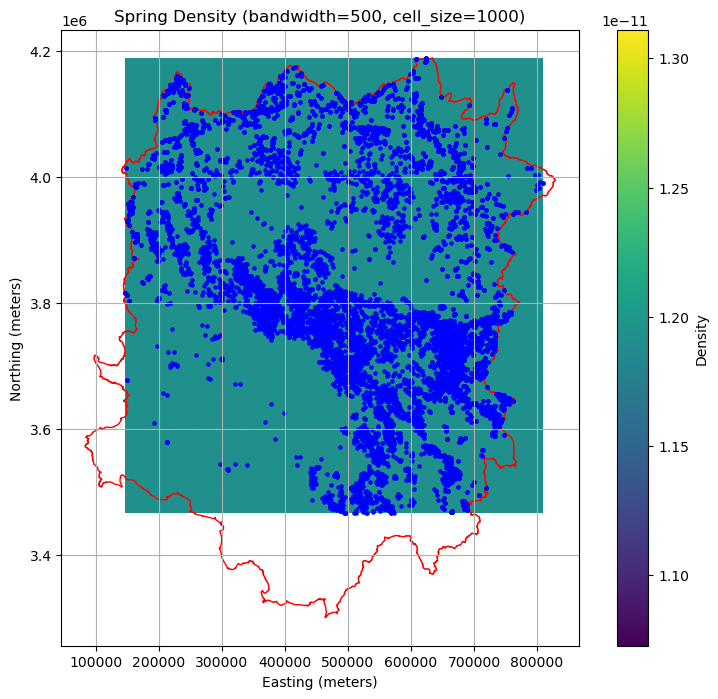

Calculating density with bandwidth=1000 and cell_size=500


Calculating Density: 100%|█████████████████████████████████████████████████| 1914744/1914744 [16:53<00:00, 1888.77it/s]


Density min: 1.1918830505593967e-11, max: 1.1918830505593967e-11


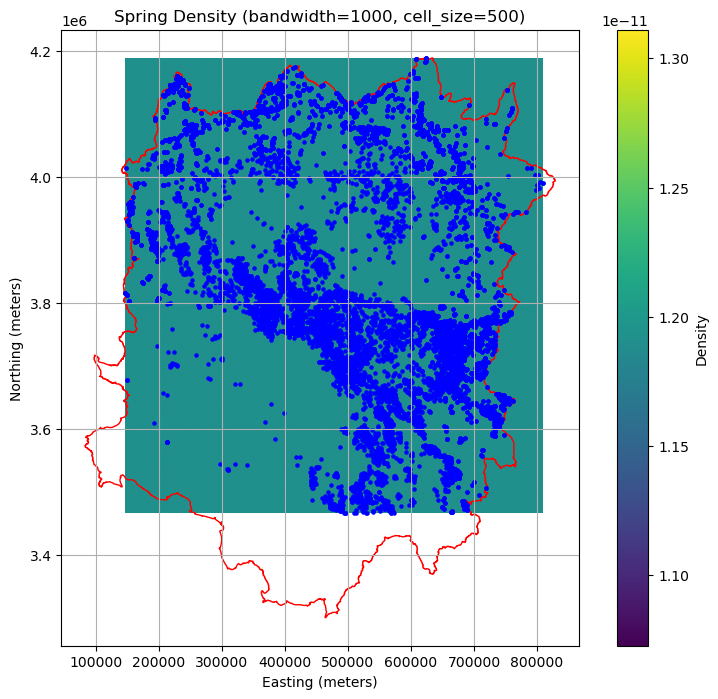

Calculating density with bandwidth=1000 and cell_size=1000


Calculating Density: 100%|███████████████████████████████████████████████████| 478686/478686 [02:08<00:00, 3724.35it/s]


Density min: 2.9797076244915605e-12, max: 2.9797076244915605e-12


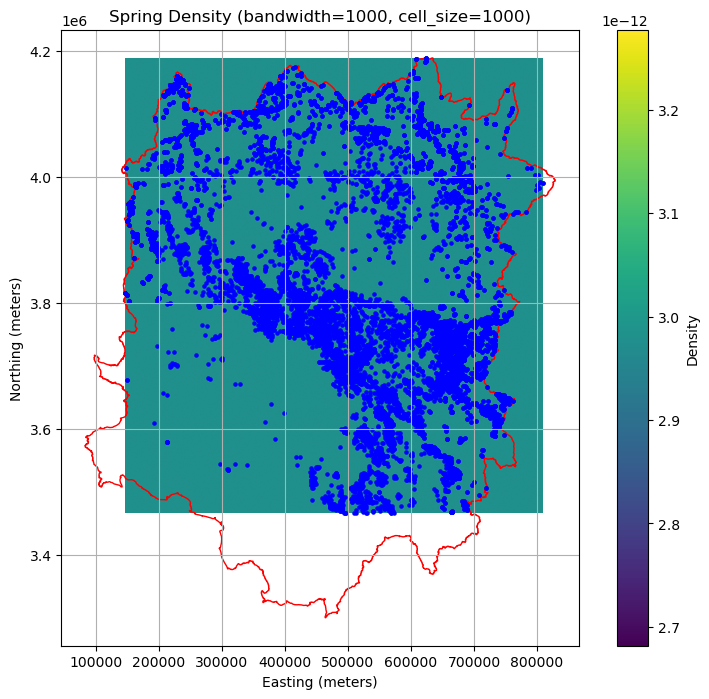

Calculating density with bandwidth=2000 and cell_size=500


Calculating Density: 100%|█████████████████████████████████████████████████| 1914744/1914744 [17:05<00:00, 1867.59it/s]


Density min: 2.979713734549712e-12, max: 2.979713734549712e-12


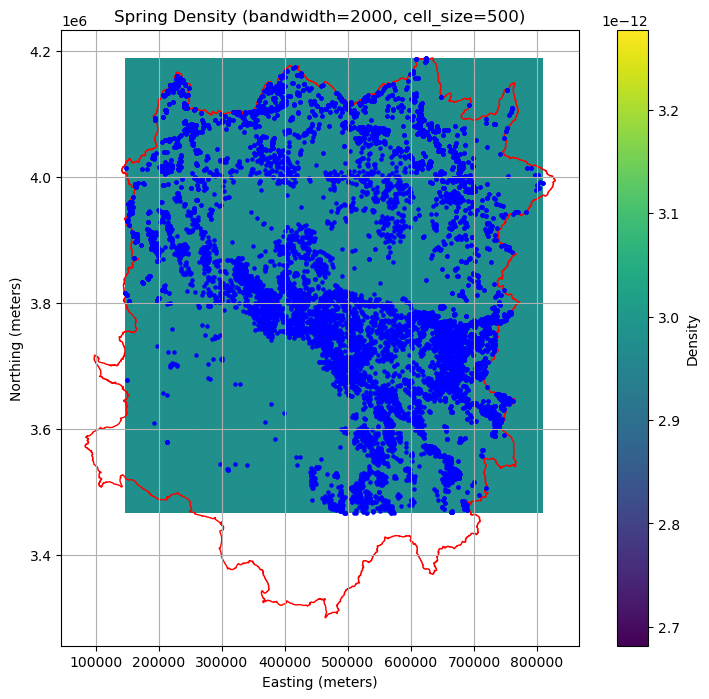

Calculating density with bandwidth=2000 and cell_size=1000


Calculating Density: 100%|███████████████████████████████████████████████████| 478686/478686 [02:10<00:00, 3677.17it/s]


Density min: 7.449284335182442e-13, max: 7.449284335182442e-13


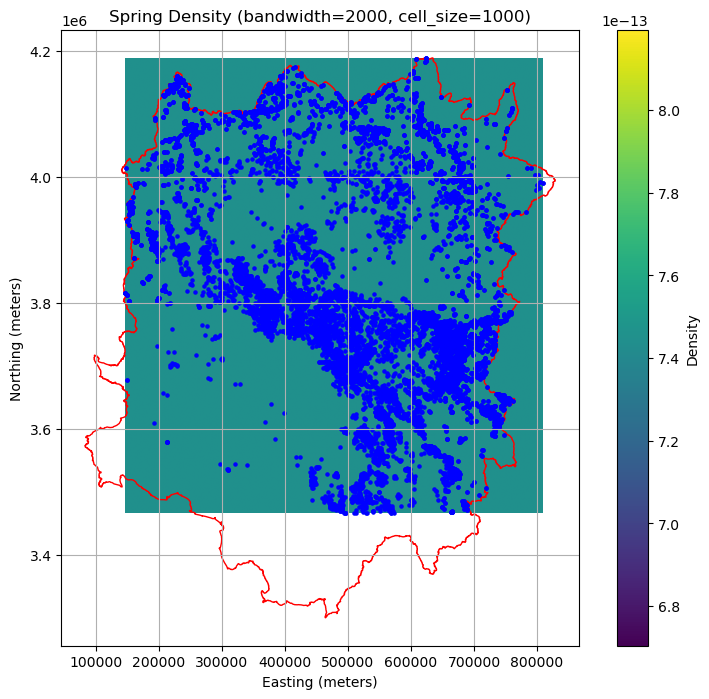

In [15]:
# Experiment with different bandwidth and cell size values
bandwidth_values = [500, 1000, 2000]
cell_size_values = [500, 1000]

tryn = 0
for bandwidth in bandwidth_values:
    for cell_size in cell_size_values:
        
        print(f"Calculating density with bandwidth={bandwidth} and cell_size={cell_size}")
        tryn = tryn +1
        # Calculate density
        x_grid, y_grid, density = calculate_point_density(gdf_spring, bandwidth, cell_size)
        
        # Check the range of density values
        print(f"Density min: {density.min()}, max: {density.max()}")
        
        # Step 5: Visualize the density
        fig, ax = plt.subplots(figsize=(10, 8))
        gdf_bound.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)  # Plot boundary with no fill color
        im = ax.imshow(np.rot90(density), cmap='viridis', extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()])
        ax.scatter(gdf_spring.geometry.x, gdf_spring.geometry.y, c='blue', s=5)  # Plot spring points
        
        # Customize plot
        ax.set_title(f'Spring Density (bandwidth={bandwidth}, cell_size={cell_size})')
        ax.set_xlabel('Easting (meters)')
        ax.set_ylabel('Northing (meters)')
        ax.grid(True)
        
        # Remove scientific notation from the y-axis
        ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
        
        # Add colorbar
        plt.colorbar(im, ax=ax, label='Density')
        plt.show()